# Experiments to build AI conversational tools

### Uses cases:

* I/O definitions:
    * Input: 
        - Use case 1: requires name of "equipment" to identify "equipmetn group"
        - Use case 2: requines Yes/No answers to navigate on tree of questions
    * Output:
        - Use case 1: Output table with criteria columns 1 to 7 and 8a 
        - Use case 2: Output table with criteria columns 1 to 7, 8a and also 8b

* Use case 1: RAG compute probs of historical records:
    * System ask to SME for equipment to start analysis (system has some tolerance to admit synonims and misspeling)
    * System classify equipment in one of the known equipment group categories in DB, reporting to user equipment group
    * System reports to user stadistics for 1 to 8a question based on historical data of equipment group

* Use case 2: Question 8a and 8b
    * Use case 2 started after use case 1 is done.
    * If questions 8a is mojoritary "YES" for given equipment (more than 50% of historical records report YES) proceed with questionay, else end use cases with 8b field 'NO'
    * Doesn't matter the results from 1 o 7, if 8a question is yes we need to proceed with tree evaluation 
    * Questionary:
        - Ask follow-up questions in order, if user reply "NO"  end use cases with 8b field 'NO', if Answe is YES continue to next question. 
        - If usere reply "YES" to all question  end use cases with 8b field 'YES'

* Use case 3:
    * Run this uses case once uses Case 1 and Use case 2 are done.
    * Take from use case 1 answers 1 to 8a
    * Take from use case 2 answer 8b
    * Summarize all answer in one table and show final result with user


* UI requirements:
    * Chat window to get user inputs
    * Chat window to visualize LLM answers
    * Button to upload new files??  (optional)
    * Button to run offline task to pre compute equipment probs?? (optional)


In [1]:
import os
print(os.getcwd())
os.chdir("c:/Users/Jonathan_Espinosa/Projects/novartis/system_impact_classification")
print(os.getcwd())

c:\Users\Jonathan_Espinosa\Projects\novartis\system_impact_classification\playground
c:\Users\Jonathan_Espinosa\Projects\novartis\system_impact_classification


In [2]:
import os
from typing import List, Optional, Annotated
from typing_extensions import TypedDict
from operator import add
import pandas as pd
from dotenv import load_dotenv
from langchain.tools import  tool
from langchain_openai import AzureChatOpenAI
from langchain_core.messages import HumanMessage
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, ToolMessage
from langgraph.graph.message import add_messages
from langgraph.graph import END, START, StateGraph, MessagesState

In [34]:
from config import config
from custom_rag import get_equipment_scores

In [94]:
load_dotenv()
AZURE_OPENAI_API_VERSION = os.getenv("AZURE_OPENAI_API_VERSION")
AZURE_OPENAI_ENDPOINT = os.getenv("AZURE_OPENAI_ENDPOINT") 
AZURE_OPENAI_API_KEY = os.getenv("AZURE_OPENAI_API_KEY")
AZURE_OPENAI_CHAT_DEPLOYMENT_NAME = os.getenv("AZURE_OPENAI_CHAT_DEPLOYMENT_NAME") 

llm = AzureChatOpenAI(
    openai_api_version=os.environ["AZURE_OPENAI_API_VERSION"],
    azure_deployment=os.environ["AZURE_OPENAI_CHAT_DEPLOYMENT_NAME"],
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

In [105]:
# The structure of the logs
"""
class EntryGraphState(TypedDict):
    id: str
    counter: int = 0
    clinical_history: Optional[str]
    messages_human: Annotated[List[HumanMessage], add_messages]
    #messages_agent: Annotated[List[str], add]
    context: Optional[List[str]] # also Union[]
    id_trials_valid: Annotated[List[str], add]
    conversation_history: Annotated[List[SystemMessage|HumanMessage|AIMessage|ToolMessage], add_messages] # add_messages
    role_game_history: Annotated[List[HumanMessage|AIMessage], add_messages] 
"""

class AgentState(TypedDict):
    stage: int
    equipment: str
    human_message: str
    ai_message: str
    criteria_8a_status: bool
    criteria_8b_status: bool = False # Default doens't work need to update value in Node @todo check how to do 
    df_output: pd.DataFrame



In [174]:

def node_get_human_equipment(state: AgentState):
    #@todo add regex for alphabetic - Camell case - Add Guardrails?? -
    print('-----------Node get human equipment-------------------')
    equipment = state['equipment'].strip()
    stage = state['stage'] + 1
    equipment =  state['equipment']
    return {'equipment': equipment, 'stage': stage}

def node_rag(state:AgentState):
    print('-----------Node RAG-------------------')
    user_equipment = state['equipment']
    stage = state['stage'] + 1
    print(f"RAG for input: {user_equipment}")
    df_equipment_score = get_equipment_scores(user_equipment=user_equipment)
    print("RAG Output:",df_equipment_score)
    value_8a = True if df_equipment_score['Criteria 8a'].values[0]>0.5 else False
    return {'df_output': df_equipment_score,  'criteria_8a_status': value_8a, 'stage': stage, 'criteria_8b_status':False} # Default 8B false, will be update later if needed

def question_8_eval(state:AgentState):
    if state['criteria_8a_status']:
        return 'node_question_1'
    else:
        return 'node_parse_output'
    

def node_question_1(state: AgentState):
    print('-----------Node question-------------------')
    ai_message = "Does system fall on XXYY exceptpion?"
    human_message_question_8b = state['human_message']
    print(ai_message ,  human_message_question_8b)
    return {'ai_message': ai_message, 'criteria_8b_status': human_message_question_8b}


def node_parse_output(state:AgentState):
    df_output = state['df_output']
    df_output['Criteria 8a'] = [state['criteria_8a_status']]
    df_output['Criteria 8b'] =  [state['criteria_8b_status']]
    print('-----------Node output-------------------')
    print(df_output)
    return {'df_output': df_output}


## 1. FLOW Version 1

In [175]:
# Node definitions
builder = StateGraph(AgentState)
builder.add_node("node_get_human_equipment", node_get_human_equipment)
builder.add_node("node_rag", node_rag)
builder.add_node("node_question_1", node_question_1)
builder.add_node("node_parse_output", node_parse_output)

# Node edges:
builder.add_edge(START, "node_get_human_equipment")
builder.add_edge("node_get_human_equipment", "node_rag")
builder.add_conditional_edges("node_rag", question_8_eval)
builder.add_edge("node_question_1", "node_parse_output")
builder.add_edge("node_parse_output", END)


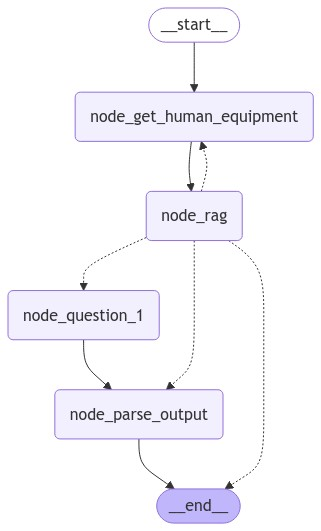

In [176]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver

# You MUST use a checkpoiner when using breakpoints. This is because your graph needs to be able to resume execution. (https://langchain-ai.github.io/langgraph/concepts/low_level/#configuration)
memory = MemorySaver()
graph = builder.compile()
# graph = builder.compile(checkpointer=memory) #   interrupt_before=['human_feedback'])


# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [185]:

# config = {"configurable": {"thread_id": "1"}}
#graph.invoke({"stage":0, "equipment":"Freezer", 'human_message': False}, config)
# Cooling 8a-->1     Drying 8a->0
result = graph.invoke({"stage":0, "equipment":"Coler", 'human_message': True}) 

-----------Node get human equipment-------------------
-----------Node RAG-------------------
RAG for input: Coler
Equipment category analysis:  equipment_group_name='Cooling' new_equipment='Coler' classification_score=80
RAG Output:   equipment_group_name  Criteria 1  Criteria 2  Criteria 3  Criteria 4  \
1              Cooling         1.0         0.0         1.0         0.0   

   Criteria 5  Criteria 6  Criteria 7  Criteria 8a  Criteria 8b equipment_name  
1         1.0         0.0         1.0          1.0          0.0          Coler  
-----------Node question-------------------
Does system fall on XXYY exceptpion? True
-----------Node output-------------------
  equipment_group_name  Criteria 1  Criteria 2  Criteria 3  Criteria 4  \
1              Cooling         1.0         0.0         1.0         0.0   

   Criteria 5  Criteria 6  Criteria 7  Criteria 8a  Criteria 8b equipment_name  
1         1.0         0.0         1.0         True         True          Coler  


In [186]:
result['df_output']

,equipment_group_name,Criteria 1,Criteria 2,Criteria 3,Criteria 4,Criteria 5,Criteria 6,Criteria 7,Criteria 8a,Criteria 8b,equipment_name
1,Cooling,1.0,0.0,1.0,0.0,1.0,0.0,1.0,True,True,Coler
